# TV regularization

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

import pylops

from scipy.sparse import csr_matrix, vstack, rand
from scipy.linalg import lstsq, solve, pinv
from scipy.sparse.linalg import LinearOperator as spLinearOperator
from scipy.sparse.linalg import cg, lsqr

from pylops.utils                      import dottest
from pylops.utils.wavelets             import *
from pylops.utils.seismicevents        import *
from pylops.basicoperators             import *
from pylops.signalprocessing           import *
from pylops.waveeqprocessing.mdd       import *
from pylops.optimization.leastsquares  import *
from pylops.optimization.sparsity  import SplitBregman

In this notebook we will use the *Split Bregman* solver to solve the following unconstrained least-squares problem with multiple L1 constraints:

$$ J =  \mu/2 ||\textbf{b} - \textbf{Ax} |||_2 + \sum_i ||\Phi_i(\textbf{x}) |||_1$$

More specifically we will limit ourselves to the case of $\Phi_i$ being linear

$$ J =  \mu/2 ||\textbf{b} - \textbf{Ax} |||_2 + \sum_i ||\Phi_i \textbf{x} |||_1$$

Such a problem is first casted as an equivalent constrained least-squares problem

$$ J =  \mu/2 ||\textbf{b} - \textbf{Ax} |||_2 + \sum_i ||d_i|||_1  \quad subj.to \quad \Phi_i \textbf{x} = d_i$$

and then solved as an augmented unconstrained equivalent

$$ J = \sum_i ||d_i||_1 + \sum_i \lambda_i/2 ||d_i -  \Phi_i \textbf{x}|||_2 + \mu/2 ||\textbf{b} - \textbf{Ax} |||_2 $$

## Denoising

### 1D

$$ J =  \mu/2 ||\textbf{y} - \textbf{x} |||_2 +  ||\nabla \textbf{x}|||_1$$

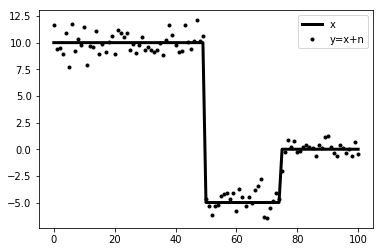

In [2]:
np.random.seed(1)

nx = 101
x = np.zeros(nx)
x[:nx//2] = 10
x[nx//2:3*nx//4] = -5

Dop = FirstDerivative(nx, edge=True)
D2op = SecondDerivative(nx, edge=True)
Iop = Identity(nx)

n = np.random.normal(0, 1, nx)
y = Iop*(x + n)
ymask = y.copy()
#y = Rop*(x + n)
#ymask = Rop.mask(x) + n

plt.figure()
plt.plot(x, 'k', lw=3, label='x')
plt.plot(ymask, '.k', label='y=x+n')
plt.legend()

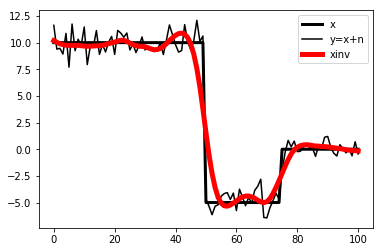

In [3]:
lamda = 1e2
xinv = RegularizedInversion(Iop, [D2op], y, epsRs=[np.sqrt(lamda/2)],
                            **dict(iter_lim=30))

plt.figure()
plt.plot(x, 'k', lw=3, label='x')
plt.plot(ymask, 'k', label='y=x+n')
plt.plot(xinv, 'r', lw=5, label='xinv')
plt.legend()

100


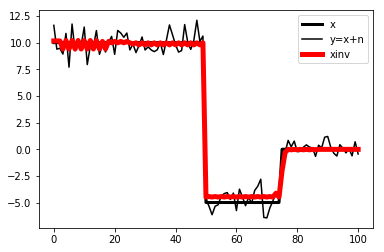

In [4]:
mu = 0.01
lamda = 0.2
niter = 100
niterinner = 3

xinv_f, niter_f = SplitBregman(Iop, [Dop], y, niter, niterinner, mu=mu, epsRL1s=[lamda], 
                               tol=1e-4, tau=1, **dict(iter_lim=30, damp=1e-3))
print(niter)

plt.figure()
plt.plot(x, 'k', lw=3, label='x')
plt.plot(ymask, 'k', label='y=x+n')
plt.plot(xinv_f, 'r', lw=5, label='xinv')
plt.legend();

### 2D

$$ J =  \mu/2 ||\textbf{y} - \textbf{x} |||_2 +  ||\nabla_x \textbf{x}|||_1  +  ||\nabla_y \textbf{x}|||_1$$

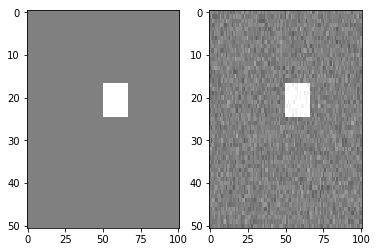

In [5]:
ny, nx = 51, 101
x = np.zeros((ny, nx))
x[ny//3:ny//2, nx//2:2*nx//3] = 1

Iop = Identity(ny*nx)
Dop = [FirstDerivative(ny*nx, dims=(ny, nx), dir=0, edge=True),
       FirstDerivative(ny*nx, dims=(ny, nx), dir=1, edge=True)]
D2op = Laplacian(dims=(ny, nx), edge=True)

n = np.random.normal(0, 0.1, (ny, nx))
y = Iop*(x.flatten() + n.flatten())
y = y.reshape(ny, nx)

fig, axs = plt.subplots(1, 2)
axs[0].imshow(x, vmin=-1, vmax=1, cmap='gray')
axs[0].axis('tight')
axs[1].imshow(y, vmin=-1, vmax=1, cmap='gray')
axs[1].axis('tight');

100


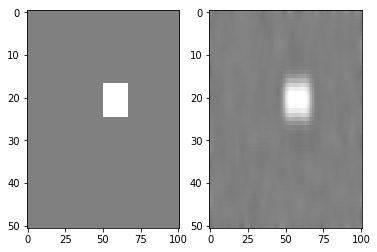

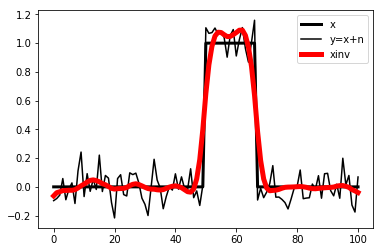

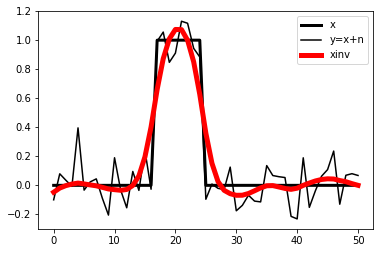

In [6]:
lamda = 1e1
xinv_sm = RegularizedInversion(Iop, [D2op], y.flatten(), epsRs=[np.sqrt(lamda/2)],
                            **dict(iter_lim=30))
xinv_sm = xinv_sm.reshape(ny, nx)
print(niter)

fig, axs = plt.subplots(1, 2)
axs[0].imshow(x, vmin=-1, vmax=1, cmap='gray')
axs[0].axis('tight')
axs[1].imshow(xinv_sm, vmin=-1, vmax=1, cmap='gray')
axs[1].axis('tight')

plt.figure()
plt.plot(x[20], 'k', lw=3, label='x')
plt.plot(y[20], 'k', label='y=x+n')
plt.plot(xinv_sm[20], 'r', lw=5, label='xinv')
plt.legend();

plt.figure()
plt.plot(x[:, 60], 'k', lw=3, label='x')
plt.plot(y[:, 60], 'k', label='y=x+n')
plt.plot(xinv_sm[:, 60], 'r', lw=5, label='xinv')
plt.legend();

20


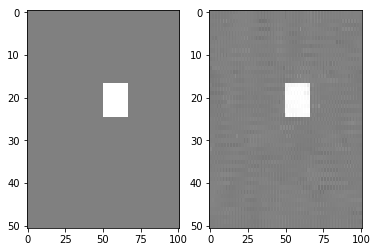

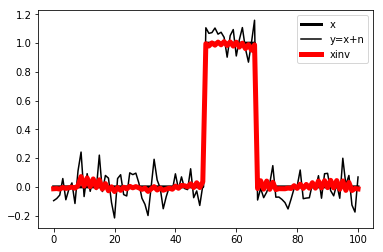

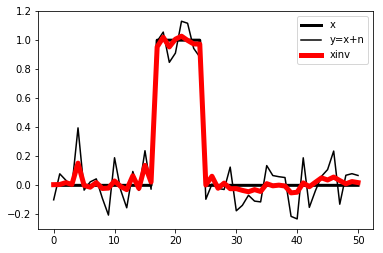

In [7]:
mu = 1.4
lamda = [0.3, 0.5]
niter = 20
niterinner = 1

xinv_f, niter_f = SplitBregman(Iop, Dop, y.flatten(), niter, niterinner, mu=mu, epsRL1s=lamda, 
                               tol=1e-4, tau=1., x0=xinv_sm.flatten(), **dict(iter_lim=30, damp=1e-10))
xinv_f = xinv_f.reshape(ny, nx)
print(niter)

fig, axs = plt.subplots(1, 2)
axs[0].imshow(x, vmin=-1, vmax=1, cmap='gray')
axs[0].axis('tight')
axs[1].imshow(xinv_f, vmin=-1, vmax=1, cmap='gray')
axs[1].axis('tight')

plt.figure()
plt.plot(x[20], 'k', lw=3, label='x')
plt.plot(y[20], 'k', label='y=x+n')
plt.plot(xinv_f[20], 'r', lw=5, label='xinv')
plt.legend();

plt.figure()
plt.plot(x[:, 60], 'k', lw=3, label='x')
plt.plot(y[:, 60], 'k', label='y=x+n')
plt.plot(xinv_f[:, 60], 'r', lw=5, label='xinv')
plt.legend();

Finally blocky in one direction and smooth in the other

50


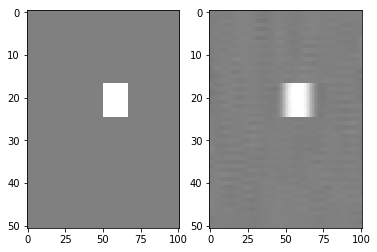

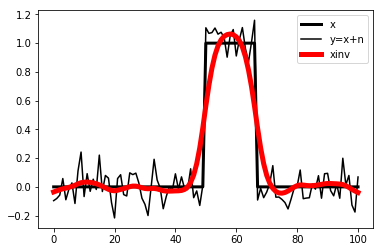

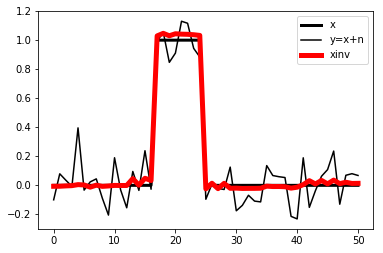

In [8]:
mu = 1.4
lamda = [0.3, 0.5]
niter = 50
niterinner = 1

Dop = [FirstDerivative(ny*nx, dims=(ny, nx), dir=0, edge=True),
       SecondDerivative(ny*nx, dims=(ny, nx), dir=1, edge=True)]

xinv_f, niter_f = SplitBregman(Iop, [Dop[0]], y.flatten(), niter, niterinner, mu=mu, epsRL1s=[lamda[0]],
                               RegsL2=[Dop[1]], epsRL2s=[100*lamda[1]], tol=1e-4, tau=1., 
                                 x0=xinv_sm.flatten(), **dict(iter_lim=30, damp=1e-2))
xinv_f = xinv_f.reshape(ny, nx)
print(niter)

fig, axs = plt.subplots(1, 2)
axs[0].imshow(x, vmin=-1, vmax=1, cmap='gray')
axs[0].axis('tight')
axs[1].imshow(xinv_f, vmin=-1, vmax=1, cmap='gray')
axs[1].axis('tight')

plt.figure()
plt.plot(x[20], 'k', lw=3, label='x')
plt.plot(y[20], 'k', label='y=x+n')
plt.plot(xinv_f[20], 'r', lw=5, label='xinv')
plt.legend();

plt.figure()
plt.plot(x[:, 60], 'k', lw=3, label='x')
plt.plot(y[:, 60], 'k', label='y=x+n')
plt.plot(xinv_f[:, 60], 'r', lw=5, label='xinv')
plt.legend();

## MRI imaging

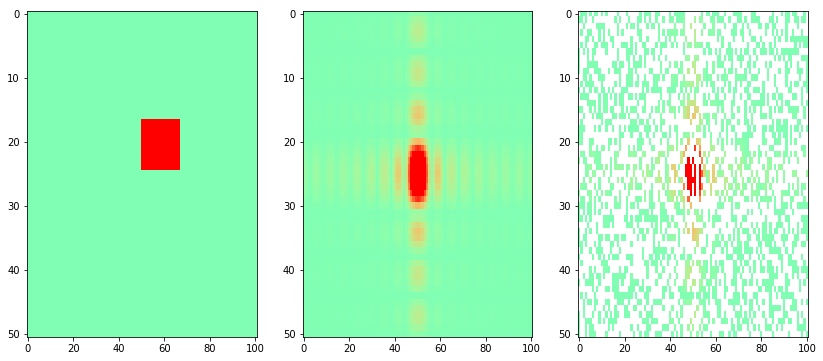

In [9]:
np.random.seed(1)

ny, nx = 51, 101
x = np.zeros((ny, nx))
x[ny//3:ny//2, nx//2:2*nx//3] = 1

perc_subsampling=0.4
nxsub=int(np.round(ny*nx*perc_subsampling))
iava = np.sort(np.random.permutation(np.arange(ny*nx))[:nxsub])
Rop = Restriction(ny*nx, iava, dtype=np.complex)
Fop = FFT2D(dims=(ny, nx))

n = np.random.normal(0, 0.0, (ny, nx))
y = Rop*(Fop*x.flatten() + n.flatten())
yfft = Fop*x.flatten() + n.flatten()
yfft = np.fft.fftshift(yfft.reshape(ny,nx))

ymask = Rop.mask(Fop*(x.flatten()) + n.flatten())
ymask = ymask.reshape(ny, nx)
ymask.data[:] = np.fft.fftshift(ymask.data)
ymask.mask[:] = np.fft.fftshift(ymask.mask)

fig, axs = plt.subplots(1, 3, figsize=(14, 6))
axs[0].imshow(x, vmin=-1, vmax=1, cmap='rainbow')
axs[0].axis('tight')
axs[1].imshow(np.abs(yfft), vmin=-1, vmax=1, cmap='rainbow')
axs[1].axis('tight');
axs[2].imshow(np.abs(ymask), vmin=-1, vmax=1, cmap='rainbow')
axs[2].axis('tight');

Regularized LS and sparse with anisotropic TV regularization

Split-Bregman optimization
---------------------------------------------------------
The Operator Op has 2060 rows and 5151 cols
niter_outer =  20     niter_inner =  10   tol = 1.00e-04
mu = 1.50e+00         epsL1 = [0.3, 0.3]	  epsL2 = None     
---------------------------------------------------------

   Itn          x[0]           r2norm          r12norm
     1  -5.83801e-02        1.359e-01        2.113e+02
     2  -5.04839e-02        3.598e-01        1.550e+02
     3  -3.20266e-02        3.386e-01        6.484e+01
     4  -3.19273e-02        3.132e-01        6.301e+01
     5  -3.25059e-02        2.951e-01        6.113e+01
     6  -3.26991e-02        2.796e-01        5.994e+01
     7  -3.28156e-02        2.662e-01        5.896e+01
     8  -3.28969e-02        2.545e-01        5.811e+01
     9  -3.29545e-02        2.442e-01        5.737e+01
    10  -3.29955e-02        2.352e-01        5.672e+01
    11  -3.30242e-02        2.272e-01        5.614e+01
    12  -3.30428e-02        2.201e

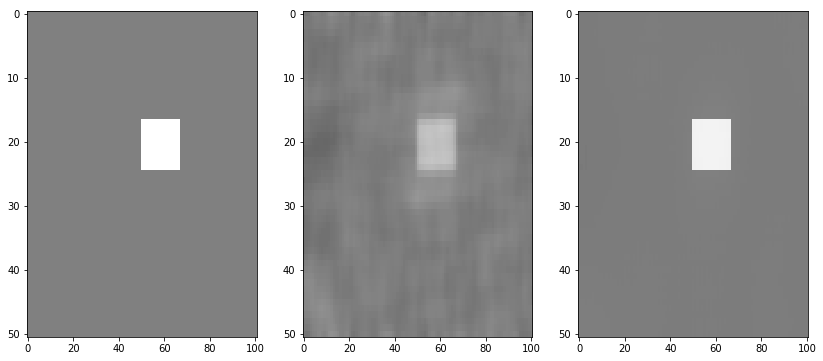

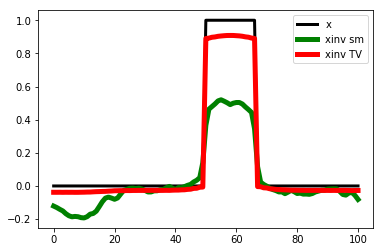

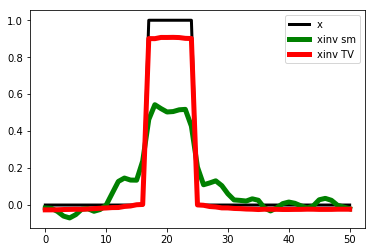

In [10]:
Dop = [FirstDerivative(ny*nx, dims=(ny, nx), dir=0, edge=True, dtype=np.complex),
       FirstDerivative(ny*nx, dims=(ny, nx), dir=1, edge=True, dtype=np.complex)]
D2op = Laplacian(dims=(ny, nx), edge=True, dtype=np.complex)


# L2
xinv_sm = RegularizedInversion(Rop*Fop, [D2op], y.flatten(), epsRs=[5e-1],
                               **dict(iter_lim=30))
xinv_sm = np.real(xinv_sm.reshape(ny, nx))

# TV
mu = 1.5
lamda = [0.3, 0.3]
niter = 20
niterinner = 10

xinv, niter = SplitBregman(Rop*Fop, Dop, y.flatten(), niter, niterinner, mu=mu, epsRL1s=lamda,
                           tol=1e-4, tau=1., show=True, **dict(iter_lim=30, damp=1e-5))
xinv = np.real(xinv.reshape(ny, nx))

fig, axs = plt.subplots(1, 3, figsize=(14, 6))
axs[0].imshow(x, vmin=-1, vmax=1, cmap='gray')
axs[0].axis('tight')
axs[1].imshow(xinv_sm, vmin=-1, vmax=1, cmap='gray')
axs[1].axis('tight')
axs[2].imshow(xinv, vmin=-1, vmax=1, cmap='gray')
axs[2].axis('tight')

plt.figure()
plt.plot(x[20], 'k', lw=3, label='x')
plt.plot(xinv_sm[20], 'g', lw=5, label='xinv sm')
plt.plot(xinv[20], 'r', lw=5, label='xinv TV')
plt.legend();

plt.figure()
plt.plot(x[:, 60], 'k', lw=3, label='x')
plt.plot(xinv_sm[:, 60], 'g', lw=5, label='xinv sm')
plt.plot(xinv[:, 60], 'r', lw=5, label='xinv TV')
plt.legend();

Similar but with isotropic TV regularization

Split-Bregman optimization
---------------------------------------------------------
The Operator Op has 2060 rows and 5151 cols
niter_outer =  20     niter_inner =  10   tol = 1.00e-04
mu = 1.50e+00         epsL1 = [0.1]	  epsL2 = None     
---------------------------------------------------------

   Itn          x[0]           r2norm          r12norm
     1  -2.39404e-02        5.698e-03        1.094e+02
     2  -2.44579e-02        5.601e-03        5.112e+01
     3  -2.41655e-02        5.284e-03        5.007e+01
     4  -2.51438e-02        5.110e-03        4.940e+01
     5  -2.55030e-02        4.976e-03        4.914e+01
     6  -2.57424e-02        4.856e-03        4.899e+01
     7  -2.61269e-02        4.746e-03        4.888e+01
     8  -2.65805e-02        4.644e-03        4.879e+01
     9  -2.68846e-02        4.550e-03        4.872e+01
    10  -2.68962e-02        4.463e-03        4.868e+01
    11  -2.66734e-02        4.382e-03        4.864e+01
    12  -2.64496e-02        4.308e-03  

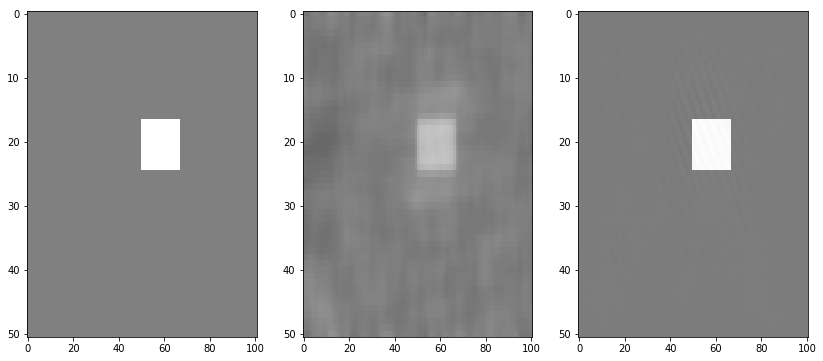

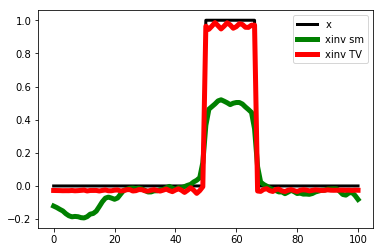

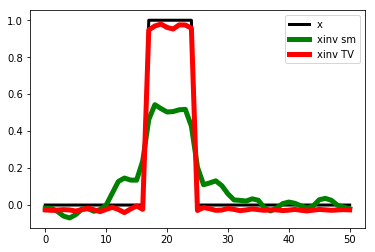

In [11]:
Dop = [FirstDerivative(ny*nx, dims=(ny, nx), dir=0, edge=False, dtype=np.complex) + 
       FirstDerivative(ny*nx, dims=(ny, nx), dir=1, edge=False, dtype=np.complex)]
D2op = Laplacian(dims=(ny, nx), edge=True, dtype=np.complex)

# TV
mu = 1.5
lamda = [0.1]
niter = 20
niterinner = 10

xinv, niter = SplitBregman(Rop*Fop, Dop, y.flatten(), niter, niterinner, mu=mu, epsRL1s=lamda,
                           tol=1e-4, tau=1., show=True, **dict(iter_lim=30, damp=1e-5))
xinv = np.real(xinv.reshape(ny, nx))

fig, axs = plt.subplots(1, 3, figsize=(14, 6))
axs[0].imshow(x, vmin=-1, vmax=1, cmap='gray')
axs[0].axis('tight')
axs[1].imshow(xinv_sm, vmin=-1, vmax=1, cmap='gray')
axs[1].axis('tight')
axs[2].imshow(xinv, vmin=-1, vmax=1, cmap='gray')
axs[2].axis('tight')

plt.figure()
plt.plot(x[20], 'k', lw=3, label='x')
plt.plot(xinv_sm[20], 'g', lw=5, label='xinv sm')
plt.plot(xinv[20], 'r', lw=5, label='xinv TV')
plt.legend();

plt.figure()
plt.plot(x[:, 60], 'k', lw=3, label='x')
plt.plot(xinv_sm[:, 60], 'g', lw=5, label='xinv sm')
plt.plot(xinv[:, 60], 'r', lw=5, label='xinv TV')
plt.legend();

We do the same with the Shepp Logan phantom

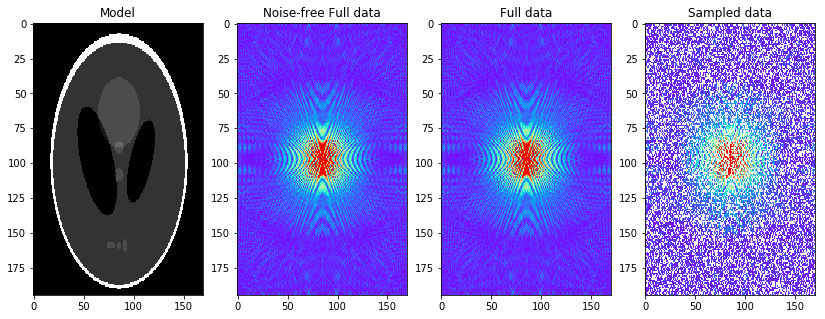

In [12]:
np.random.seed(1)

x = np.load('../data/optimization/shepp_logan_phantom.npy')
x = x/x.max()
ny, nx = x.shape

perc_subsampling=0.6
nxsub=int(np.round(ny*nx*perc_subsampling))
iava = np.sort(np.random.permutation(np.arange(ny*nx))[:nxsub])
Rop = pylops.Restriction(ny*nx, iava, dtype=np.complex)
Fop = pylops.signalprocessing.FFT2D(dims=(ny, nx))

n = np.random.normal(0, 1e-3, (ny, nx))
y = Rop*(Fop*x.flatten() + n.flatten())

yfft = Fop*x.flatten()
yfft = np.fft.fftshift(yfft.reshape(ny,nx))
yfftn = Fop*x.flatten() + n.flatten()
yfftn = np.fft.fftshift(yfftn.reshape(ny,nx))

ymask = Rop.mask(Fop*(x.flatten()) + n.flatten())
ymask = ymask.reshape(ny, nx)
ymask.data[:] = np.fft.fftshift(ymask.data)
ymask.mask[:] = np.fft.fftshift(ymask.mask)

fig, axs = plt.subplots(1, 4, figsize=(14, 5))
axs[0].imshow(x, vmin=0, vmax=1, cmap='gray')
axs[0].set_title('Model')
axs[0].axis('tight')
axs[1].imshow(np.abs(yfft), vmin=0, vmax=1, cmap='rainbow')
axs[1].set_title('Noise-free Full data')
axs[1].axis('tight')
axs[2].imshow(np.abs(yfftn), vmin=0, vmax=1, cmap='rainbow')
axs[2].set_title('Full data')
axs[2].axis('tight')
axs[3].imshow(np.abs(ymask), vmin=0, vmax=1, cmap='rainbow')
axs[3].set_title('Sampled data')
axs[3].axis('tight');

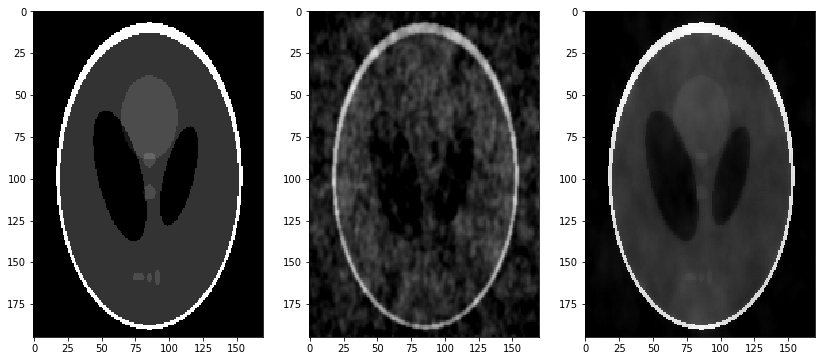

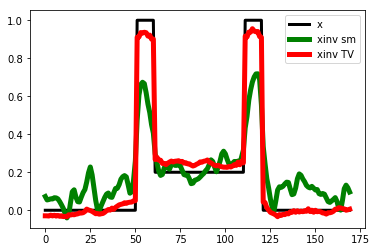

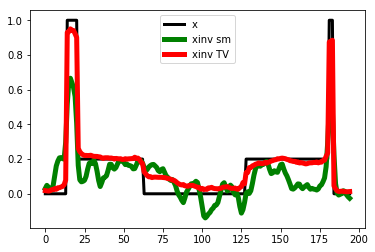

In [13]:
Dop = [FirstDerivative(ny*nx, dims=(ny, nx), dir=0, edge=True, dtype=np.complex),
       FirstDerivative(ny*nx, dims=(ny, nx), dir=1, edge=True, dtype=np.complex)]
D2op = Laplacian(dims=(ny, nx), edge=True, dtype=np.complex)

# L2
xinv_sm = RegularizedInversion(Rop*Fop, [D2op], y.flatten(), epsRs=[5e-1],
                               **dict(iter_lim=30))
xinv_sm = np.real(xinv_sm.reshape(ny, nx))

# TV
mu = 1.5
lamda = [0.3, 0.3]
niter = 5
niterinner = 10

xinv, niter = SplitBregman(Rop * Fop, Dop, y.flatten(), niter, niterinner,
                           mu=mu, epsRL1s=lamda, tol=1e-4, tau=1., show=False,
                             **dict(iter_lim=20, damp=1e-2))
xinv = np.real(xinv.reshape(ny, nx))
fig, axs = plt.subplots(1, 3, figsize=(14, 6))
axs[0].imshow(x, vmin=0, vmax=1, cmap='gray')
axs[0].axis('tight')
axs[1].imshow(xinv_sm, vmin=0, vmax=1, cmap='gray')
axs[1].axis('tight')
axs[2].imshow(xinv, vmin=0, vmax=1, cmap='gray')
axs[2].axis('tight')

plt.figure()
plt.plot(x[20], 'k', lw=3, label='x')
plt.plot(xinv_sm[20], 'g', lw=5, label='xinv sm')
plt.plot(xinv[20], 'r', lw=5, label='xinv TV')
plt.legend();

plt.figure()
plt.plot(x[:, 60], 'k', lw=3, label='x')
plt.plot(xinv_sm[:, 60], 'g', lw=5, label='xinv sm')
plt.plot(xinv[:, 60], 'r', lw=5, label='xinv TV')
plt.legend();

Split-Bregman optimization
---------------------------------------------------------
The Operator Op has 19890 rows and 33150 cols
niter_outer =  20     niter_inner =  10   tol = 1.00e-04
mu = 1.50e+00         epsL1 = [0.1]	  epsL2 = None     
---------------------------------------------------------

   Itn          x[0]           r2norm          r12norm
     1  -1.11417e-01        1.137e-01        1.291e+03
     2  -3.14003e-02        1.281e-01        1.007e+03
     3   3.22520e-02        1.242e-01        9.657e+02
     4   6.28289e-02        1.198e-01        9.524e+02
     5   5.39266e-02        1.162e-01        9.367e+02
     6   3.03738e-02        1.124e-01        9.219e+02
     7   3.14962e-03        1.089e-01        9.135e+02
     8  -2.10343e-02        1.056e-01        9.107e+02
     9  -3.93666e-02        1.025e-01        9.105e+02
    10  -5.09746e-02        9.969e-02        9.110e+02
    11  -5.65250e-02        9.722e-02        9.124e+02
    12  -5.72696e-02        9.512e-02

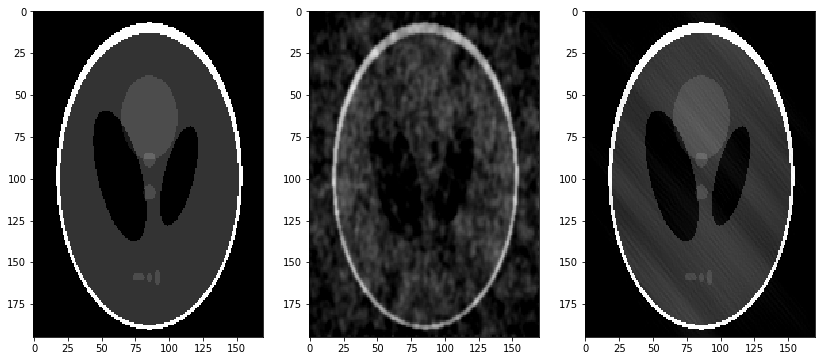

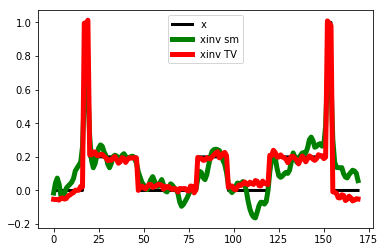

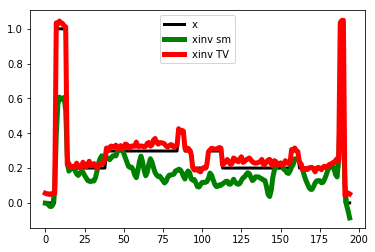

In [14]:
Dop = [FirstDerivative(ny*nx, dims=(ny, nx), dir=0, edge=False, dtype=np.complex) + \
       FirstDerivative(ny*nx, dims=(ny, nx), dir=1, edge=False, dtype=np.complex)]

# TV
mu = 1.5
lamda = [0.1]
niter = 20
niterinner = 10

xinv, niter = SplitBregman(Rop*Fop, Dop, y.flatten(), niter, niterinner, mu=mu, epsRL1s=lamda,
                           tol=1e-4, tau=1., show=True, **dict(iter_lim=5, damp=1e-5))
xinv = np.real(xinv.reshape(ny, nx))

fig, axs = plt.subplots(1, 3, figsize=(14, 6))
axs[0].imshow(x, vmin=0, vmax=1, cmap='gray')
axs[0].axis('tight')
axs[1].imshow(xinv_sm, vmin=0, vmax=1, cmap='gray')
axs[1].axis('tight')
axs[2].imshow(xinv, vmin=0, vmax=1, cmap='gray')
axs[2].axis('tight')

plt.figure()
plt.plot(x[ny//2], 'k', lw=3, label='x')
plt.plot(xinv_sm[ny//2], 'g', lw=5, label='xinv sm')
plt.plot(xinv[ny//2], 'r', lw=5, label='xinv TV')
plt.legend();

plt.figure()
plt.plot(x[:, nx//2], 'k', lw=3, label='x')
plt.plot(xinv_sm[:, nx//2], 'g', lw=5, label='xinv sm')
plt.plot(xinv[:, nx//2], 'r', lw=5, label='xinv TV')
plt.legend();

## X-RAY imaging

Here we use the linear Radon to create the dataset (see for example https://scikit-image.org/docs/dev/auto_examples/transform/plot_radon_transform.html#sphx-glr-auto-examples-transform-plot-radon-transform-py)

Note that our definition of Radon is sligtly different as we use the Spread operator that is parametrized in x,t instead of r,t. For this reason we reparametrize the curve to be function of r and theta:

$$ t(x) = tan(90-\theta)*x + r/sin(\theta) $$

In [16]:
from pylops.signalprocessing.Radon2D import _indices_2d

def radoncurve(x, r, theta):
    return r/np.sin(np.deg2rad(theta)) + np.tan(np.deg2rad(90 - theta))*x

def create_table(f, x, taxis, thetaaxis, nx, nt, ntheta):
    """Create look up table
    """
    table = np.full((ntheta, nt, nx), np.nan, dtype=np.float32)
    dt = np.abs(taxis[1]-taxis[0])
    for itheta, theta in enumerate(thetaaxis):
        for it, t in enumerate(taxis):
            tdecscan = f(x, t, theta)
            xscan = (tdecscan >= taxis[0]) & (tdecscan < taxis[-1])
            tscan = (tdecscan[xscan] - taxis[0] / dt).astype(np.int)
            table[itheta, it, xscan] = tscan
    return table

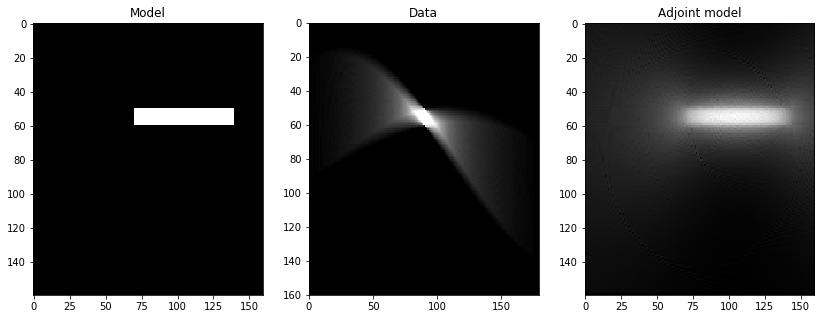

In [18]:
ny, nx = 160, 160
image = np.zeros((ny, nx))
image[50:60, 70:140] = 1

theta = np.linspace(0., 180., 200, endpoint=False)
table = create_table(radoncurve, np.arange(nx) - nx//2, np.arange(nx) - nx//2, 
                     theta, ny, nx, theta.size)
RLop = pylops.Spread((theta.size, nx), (ny, nx), table=table, engine='numba')

y = RLop.H*image.T.ravel()
y = y.reshape(theta.size, nx).T

# Filtered back-projection
imrec = RLop*y.T.ravel()
imrec = imrec.reshape(nx, ny).T

fig, axs = plt.subplots(1, 3, figsize=(14, 5))
axs[0].imshow(image, vmin=0, vmax=1, cmap='gray')
axs[0].set_title('Model')
axs[0].axis('tight')
axs[1].imshow(y, extent=(theta[0], theta[-1], ny, 0), cmap='gray')
axs[1].set_title('Data')
axs[1].axis('tight')
axs[2].imshow(imrec, cmap='gray')
axs[2].set_title('Adjoint model')
axs[2].axis('tight');

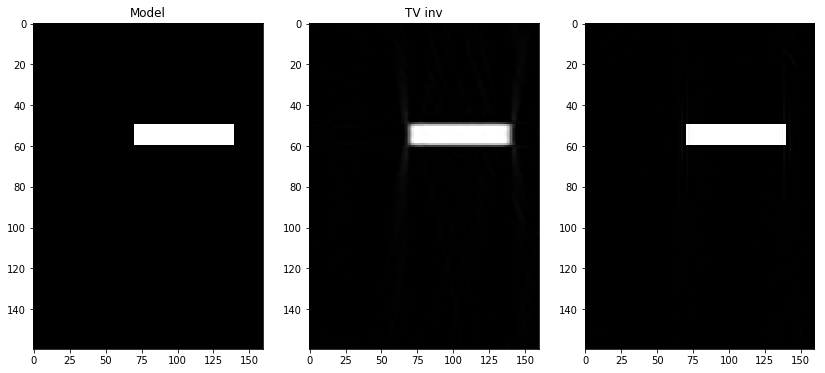

In [20]:
Dop = [FirstDerivative(ny*nx, dims=(ny, nx), dir=0, edge=True, dtype=np.float),
       FirstDerivative(ny*nx, dims=(ny, nx), dir=1, edge=True, dtype=np.float)]
D2op = Laplacian(dims=(ny, nx), edge=True, dtype=np.float)

# L2
xinv_sm = RegularizedInversion(RLop.H, [D2op], y.T.flatten(), epsRs=[1e1],
                               **dict(iter_lim=20))
xinv_sm = np.real(xinv_sm.reshape(nx, ny)).T

# TV
mu = 1.5
lamda = [1., 1.]
niter = 10
niterinner = 2

xinv, niter = SplitBregman(RLop.H, Dop, y.T.flatten(), niter, niterinner,
                           mu=mu, epsRL1s=lamda, tol=1e-4, tau=1., show=False,
                             **dict(iter_lim=20, damp=1e-2))
xinv = np.real(xinv.reshape(nx, ny)).T

fig, axs = plt.subplots(1, 3, figsize=(14, 6))
axs[0].imshow(image, vmin=0, vmax=1, cmap='gray')
axs[0].axis('tight')
axs[0].set_title('Model')
axs[1].imshow(xinv_sm, vmin=0, vmax=1, cmap='gray')
axs[1].axis('tight')
axs[1].set_title('LS inv')
axs[2].imshow(xinv, vmin=0, vmax=1, cmap='gray')
axs[2].axis('tight')
axs[1].set_title('TV inv');

In [22]:
from skimage.data import shepp_logan_phantom
from skimage.transform import rescale

image = shepp_logan_phantom()
image = rescale(image, scale=0.4, mode='reflect', multichannel=False)

ny, nx = image.shape
theta = np.linspace(0., 180., 200, endpoint=False)
table = create_table(radoncurve, np.arange(nx) - nx//2, np.arange(nx) - nx//2, 
                     theta, nx, nt, theta.size)
RLop = pylops.Spread((theta.size, nx), (ny, nx), table=table, engine='numba')

y = RLop.H*image.T.ravel()
y = y.reshape(theta.size, nx).T

# Filtered back-projection
imrec = RLop*y.T.ravel()
imrec = imrec.reshape(nx, ny).T

fig, axs = plt.subplots(1, 3, figsize=(14, 5))
axs[0].imshow(image, vmin=0, vmax=1, cmap='gray')
axs[0].set_title('Model')
axs[0].axis('tight')
axs[1].imshow(y, cmap='gray')
axs[1].set_title('Data')
axs[1].axis('tight')
axs[2].imshow(imrec, cmap='gray')
axs[2].set_title('Adjoint model')
axs[2].axis('tight');

NameError: name 'nt' is not defined

In [ ]:
Dop = [FirstDerivative(ny*nx, dims=(ny, nx), dir=0, edge=True, dtype=np.float),
       FirstDerivative(ny*nx, dims=(ny, nx), dir=1, edge=True, dtype=np.float)]
D2op = Laplacian(dims=(ny, nx), edge=True, dtype=np.float)

# L2
xinv_sm = RegularizedInversion(RLop.H, [D2op], y.T.flatten(), epsRs=[1e1],
                               **dict(iter_lim=20))
xinv_sm = np.real(xinv_sm.reshape(nx, ny)).T

# TV
mu = 1.5
lamda = [1., 1.]
niter = 10
niterinner = 2

xinv, niter = SplitBregman(RLop.H, Dop, y.T.flatten(), niter, niterinner,
                           mu=mu, epsRL1s=lamda, tol=1e-4, tau=1., show=False,
                             **dict(iter_lim=20, damp=1e-2))
xinv = np.real(xinv.reshape(nx, ny)).T

fig, axs = plt.subplots(1, 3, figsize=(14, 6))
axs[0].imshow(image, vmin=0, vmax=1, cmap='gray')
axs[0].axis('tight')
axs[1].imshow(xinv_sm, vmin=0, vmax=1, cmap='gray')
axs[1].axis('tight')
axs[2].imshow(xinv, vmin=0, vmax=1, cmap='gray')
axs[2].axis('tight')

plt.figure()
plt.plot(image[20], 'k', lw=3, label='x')
plt.plot(xinv_sm[20], 'g', lw=5, label='xinv sm')
plt.plot(xinv[20], 'r', lw=5, label='xinv TV')
plt.legend();

plt.figure()
plt.plot(image[:, 60], 'k', lw=3, label='x')
plt.plot(xinv_sm[:, 60], 'g', lw=5, label='xinv sm')
plt.plot(xinv[:, 60], 'r', lw=5, label='xinv TV')
plt.legend();

In [ ]:
image = shepp_logan_phantom()
image = rescale(image, scale=0.4, mode='reflect', multichannel=False)

theta = np.linspace(0., 180., 20, endpoint=False)
table = create_table(radoncurve, np.arange(nx) - nx//2, np.arange(nx) - nx//2, 
                     theta, nx, nt, theta.size)
RLop = pylops.Spread((theta.size, nx), (ny, nx), table=table, engine='numba')

y = RLop.H*image.T.ravel()
y = y.reshape(theta.size, nx).T

# Filtered back-projection
imrec = RLop*y.T.ravel()
imrec = imrec.reshape(nx, ny).T

fig, axs = plt.subplots(1, 3, figsize=(14, 5))
axs[0].imshow(image, vmin=0, vmax=1, cmap='gray')
axs[0].set_title('Model')
axs[0].axis('tight')
axs[1].imshow(y, cmap='gray')
axs[1].set_title('Data')
axs[1].axis('tight')
axs[2].imshow(imrec, cmap='gray')
axs[2].set_title('Adjoint model')
axs[2].axis('tight');


# L2
xinv_sm = RegularizedInversion(RLop.H, [D2op], y.T.flatten(), epsRs=[1e1],
                               **dict(iter_lim=20))
xinv_sm = np.real(xinv_sm.reshape(nx, ny)).T

# TV
mu = 1.5
lamda = [.3, .3]
niter = 5
niterinner = 4

xinv, niter = SplitBregman(RLop.H, Dop, y.T.flatten(), niter, niterinner,
                           mu=mu, epsRL1s=lamda, tol=1e-4, tau=1., show=False,
                             **dict(iter_lim=20, damp=1e-2))
xinv = np.real(xinv.reshape(nx, ny)).T

fig, axs = plt.subplots(1, 3, figsize=(14, 6))
axs[0].imshow(image, vmin=0, vmax=1, cmap='gray')
axs[0].axis('tight')
axs[1].imshow(xinv_sm, vmin=0, vmax=1, cmap='gray')
axs[1].axis('tight')
axs[2].imshow(xinv, vmin=0, vmax=1, cmap='gray')
axs[2].axis('tight')

plt.figure()
plt.plot(image[20], 'k', lw=3, label='x')
plt.plot(xinv_sm[20], 'g', lw=5, label='xinv sm')
plt.plot(xinv[20], 'r', lw=5, label='xinv TV')
plt.legend();

plt.figure()
plt.plot(image[:, 60], 'k', lw=3, label='x')
plt.plot(xinv_sm[:, 60], 'g', lw=5, label='xinv sm')
plt.plot(xinv[:, 60], 'r', lw=5, label='xinv TV')
plt.legend();